In [97]:
# import dependencies
import numpy as np
import scipy as sp
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib as jl
import datetime as dt
import requests

from icecream import ic

import os
from dotenv import load_dotenv

from ta import add_all_ta_features
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.volume import VolumeWeightedAveragePrice
from ta.momentum import StochRSIIndicator

from sklearn.model_selection import TimeSeriesSplit

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [98]:
#df = pd.read_csv('data/test_daily_df.csv')

In [99]:
def get_historical_price(tickers, data_type):

    # pulls historical daily or intraday OLHC prices and volume

    d = {}

    for i in range(len(tickers)): 

        r = requests.get('https://eodhistoricaldata.com/api' + '/' + data_type + '/' + tickers[i] + '.US', 
            params={'api_token': '63dc0e2f4efc43.34327983', 'fmt': 'json'}
            )
        data = r.json()
        r.close()

        # ADD PROGRESS BAR
        
        for symbol in tickers:
            d[symbol] = pd.DataFrame.from_records(data)

            indicator_macd = MACD(close = d[symbol]['close'], window_slow=26, window_fast=12, window_sign=9, fillna=True)
            d[symbol]['macd'] = indicator_macd.macd()
            d[symbol]['macd_diff'] = indicator_macd.macd_diff()
            d[symbol]['macd_signal'] = indicator_macd.macd_signal()

            indicator_bb = BollingerBands(close = d[symbol]['close'], window=20, window_dev=2, fillna=True)
            d[symbol]['bb_mavg'] = indicator_bb.bollinger_mavg()
            d[symbol]['bb_hband'] = indicator_bb.bollinger_hband()
            d[symbol]['bb_lband'] = indicator_bb.bollinger_lband()
            d[symbol]['bb_hband_ind'] = indicator_bb.bollinger_hband_indicator()
            d[symbol]['bb_lband_ind'] = indicator_bb.bollinger_lband_indicator()

            indicator_vwap = VolumeWeightedAveragePrice(
                high = d[symbol]['high'],
                low = d[symbol]['low'],
                close = d[symbol]['close'],
                volume = d[symbol]['volume'],
                window=14, fillna=True)
            d[symbol]['vwap'] = indicator_vwap.volume_weighted_average_price()

            indicator_stochrsi = StochRSIIndicator(close = d[symbol]['close'], window=14, smooth1=3, smooth2=3, fillna=True)
            d[symbol]['stoch_rsi'] = indicator_stochrsi.stochrsi()
            d[symbol]['stochrsi_d'] = indicator_stochrsi.stochrsi_d()
            d[symbol]['stochrsi_k'] = indicator_stochrsi.stochrsi_k()

    return d

In [100]:
# placeholder tickers
tickers = ['SPY', 'AAPL']

# get intraday prices | dictionary of dataframes
intraday_data = get_historical_price(tickers, 'intraday')

# get daily prices | dictionary of dataframes
daily_data = get_historical_price(tickers, 'eod')

In [101]:
# concat intraday dataframes together and convert to dask df
intraday_df = pd.concat(intraday_data.values(), axis=1, keys=intraday_data.keys())
intraday_dask_df = dd.from_pandas(intraday_df, npartitions=6)

# concat daily dataframes together and convert to dask df
daily_df = pd.concat(daily_data.values(), axis=1, keys=daily_data.keys())
daily_dask_df = dd.from_pandas(daily_df, npartitions=6)

#daily_df.to_csv('data/test_daily_df.csv')

In [102]:
df = daily_df['SPY'].set_index('date')


df['close_lag_1d'] = df['close'].shift(1)


In [103]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 10628 entries, 1980-12-12 to 2023-02-07
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            10628 non-null  float64
 1   high            10628 non-null  float64
 2   low             10628 non-null  float64
 3   close           10628 non-null  float64
 4   adjusted_close  10628 non-null  float64
 5   volume          10628 non-null  int64  
 6   macd            10628 non-null  float64
 7   macd_diff       10628 non-null  float64
 8   macd_signal     10628 non-null  float64
 9   bb_mavg         10628 non-null  float64
 10  bb_hband        10628 non-null  float64
 11  bb_lband        10628 non-null  float64
 12  bb_hband_ind    10628 non-null  float64
 13  bb_lband_ind    10628 non-null  float64
 14  vwap            10628 non-null  float64
 15  stoch_rsi       10628 non-null  float64
 16  stochrsi_d      10628 non-null  float64
 17  stochrsi_k      10628 

,open,high,low,close,adjusted_close,volume,macd,macd_diff,macd_signal,bb_mavg,bb_hband,bb_lband,bb_hband_ind,bb_lband_ind,vwap,stoch_rsi,stochrsi_d,stochrsi_k,close_lag_1d
date,,,,,,,,,,,,,,,,,,,
1980-12-12,28.7392,28.8736,28.7392,28.7392,0.0999,469033600,0.000000,0.000000,0.000000,28.73920,28.739200,28.739200,0.0,0.0,28.784000,0.0,0.0,0.0,NaN
1980-12-15,27.3728,27.3728,27.2608,27.2608,0.0947,175884800,-0.117935,-0.094348,-0.023587,28.00000,29.478400,26.521600,0.0,0.0,28.378768,0.0,0.0,0.0,28.7392
1980-12-16,25.3792,25.3792,25.2448,25.2448,0.0877,105728000,-0.369811,-0.276979,-0.092832,27.08160,29.945999,24.217201,0.0,0.0,27.943661,0.0,0.0,0.0,27.2608
1980-12-17,25.8720,26.0064,25.8720,25.8720,0.0899,86441600,-0.512902,-0.336056,-0.176846,26.77920,29.471956,24.086444,0.0,0.0,27.734358,0.0,0.0,0.0,25.2448
1980-12-18,26.6336,26.7456,26.6336,26.6336,0.0925,73449600,-0.558411,-0.305252,-0.253159,26.75008,29.161369,24.338791,0.0,0.0,27.648576,0.0,0.0,0.0,25.8720


In [104]:
X = df.loc[:, df.columns != 'close_lag_1d']
y = df.loc[:, 'close_lag_1d']


In [105]:
# tscv = TimeSeriesSplit(n_splits=5)

# for i, (train_index, test_index) in enumerate(tscv.split(X)):
#     print(f"Fold {i}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")

In [106]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [107]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

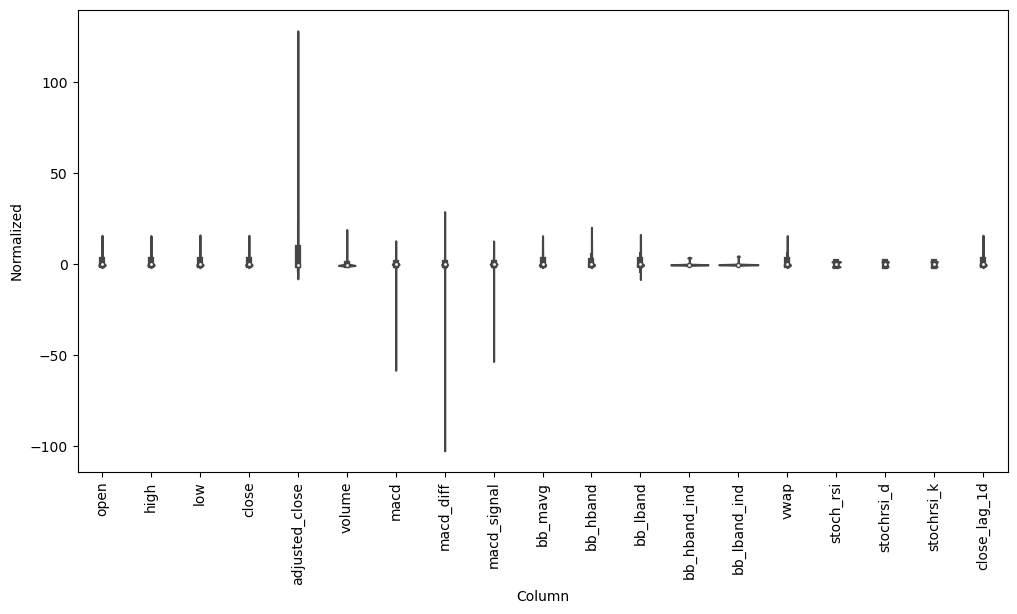

In [108]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [109]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [110]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['close_lag_1d'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['close_lag_1d']

In [111]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['close_lag_1d'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close_lag_1d']

In [112]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [113]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


In [114]:
w2.example = example_inputs, example_labels

In [115]:
def plot(self, model=None, plot_col='close_lag_1d', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

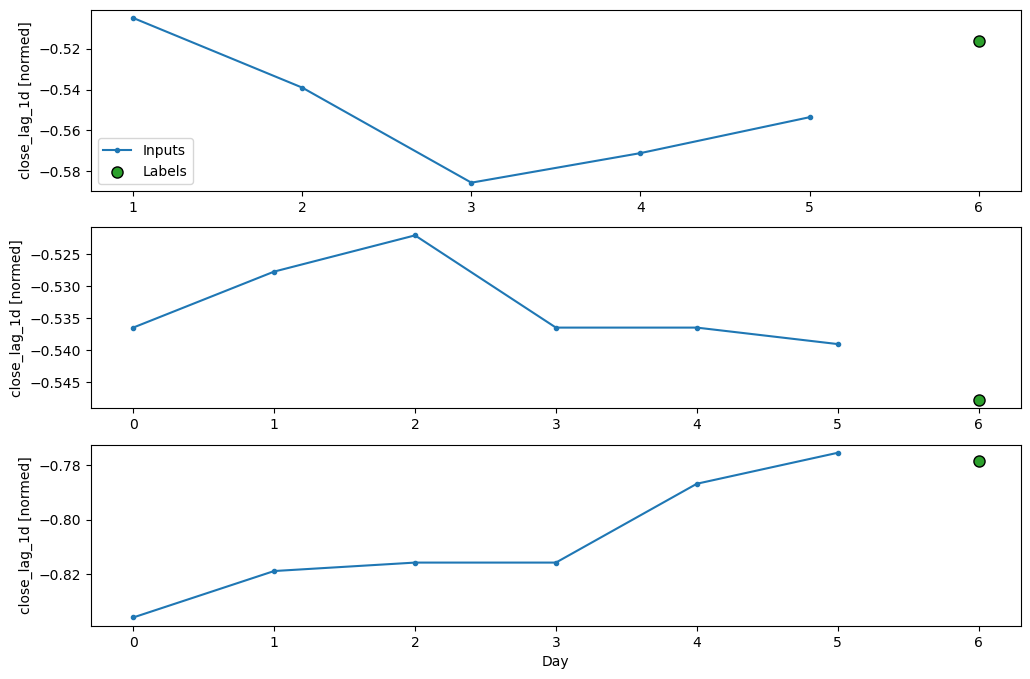

In [116]:
w2.plot()

In [171]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [172]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [173]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [174]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [175]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['close_lag_1d'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close_lag_1d']

In [176]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [177]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [178]:
baseline = Baseline(label_index=column_indices['close_lag_1d'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

67/67 [==============================] - 0s 4ms/step - loss: 0.0937 - mean_absolute_error: 0.0840


In [179]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['close_lag_1d'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close_lag_1d']

In [180]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


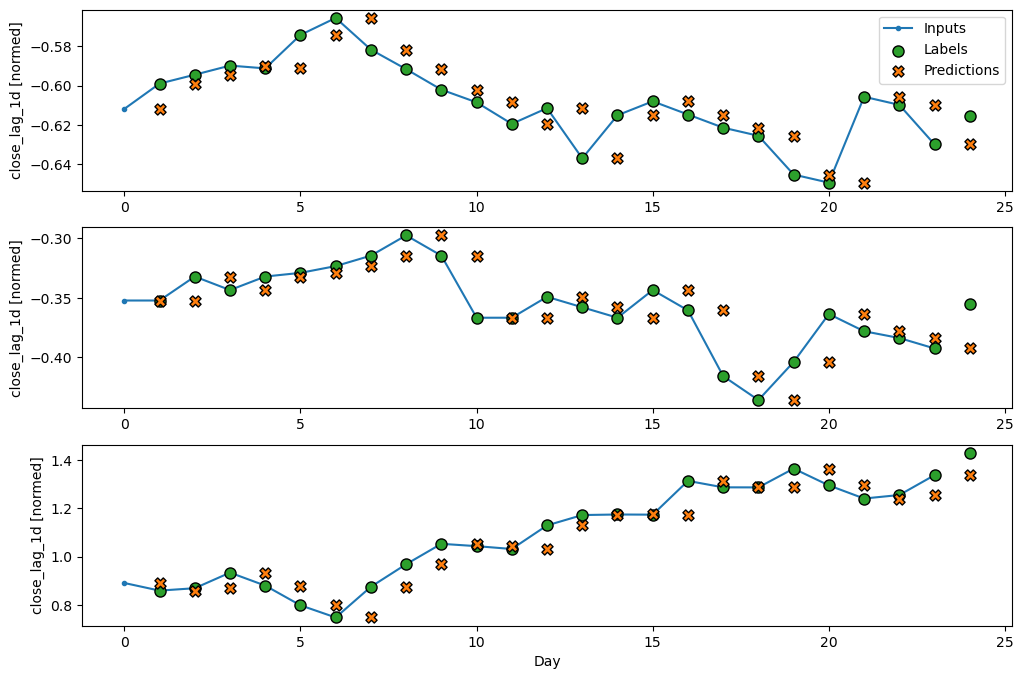

In [181]:
wide_window.plot(baseline)

In [183]:
## LINEAR

In [188]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [189]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [190]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
233/233 [==============================] - 2s 6ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
67/67 [==============================] - 0s 5ms/step - loss: nan - mean_absolute_error: nan


In [160]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (128, 24, 19)
Output shape: (128, 24, 1)


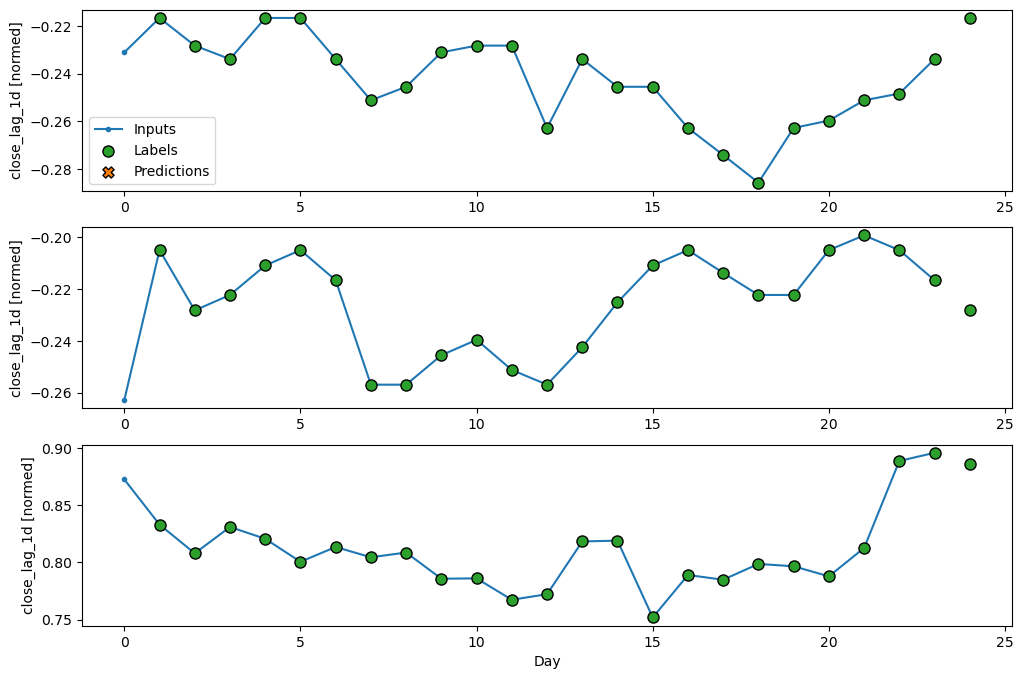

In [161]:
wide_window.plot(linear)

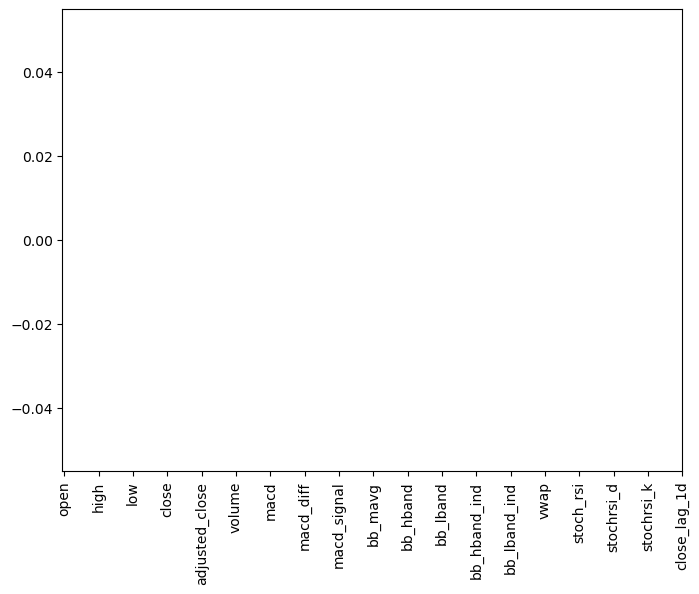

In [162]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [163]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
59/59 [==============================] - 2s 14ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: nan - mean_absolute_error: nan


In [164]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['close_lag_1d'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['close_lag_1d']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

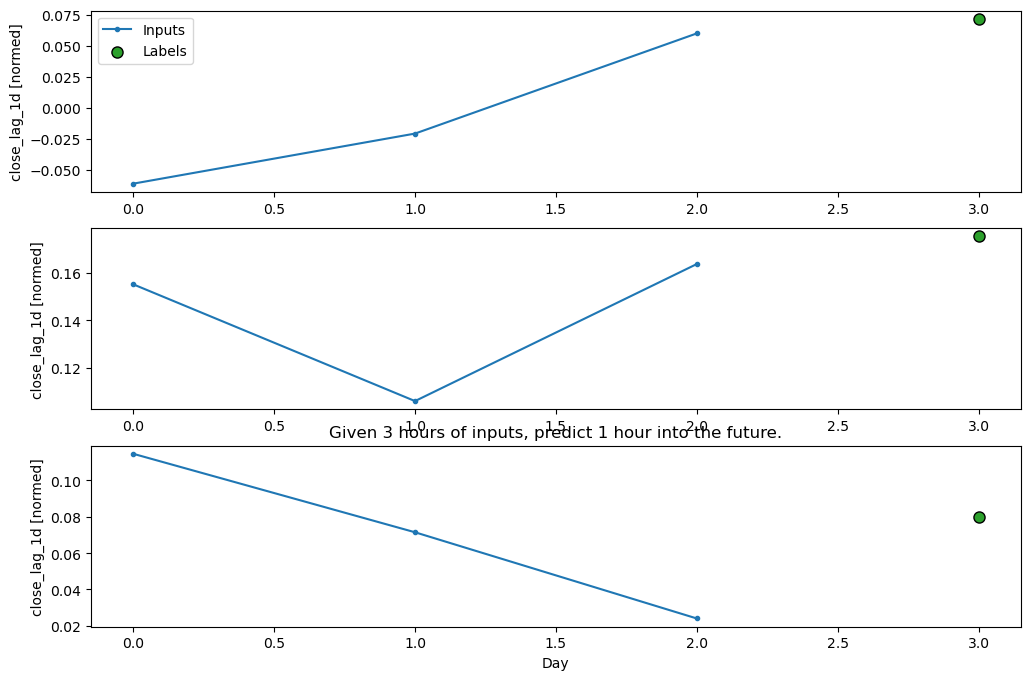

In [165]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [166]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [167]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (128, 3, 19)
Output shape: (128, 1, 1)


In [168]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

17/17 [==============================] - 0s 5ms/step - loss: nan - mean_absolute_error: nan


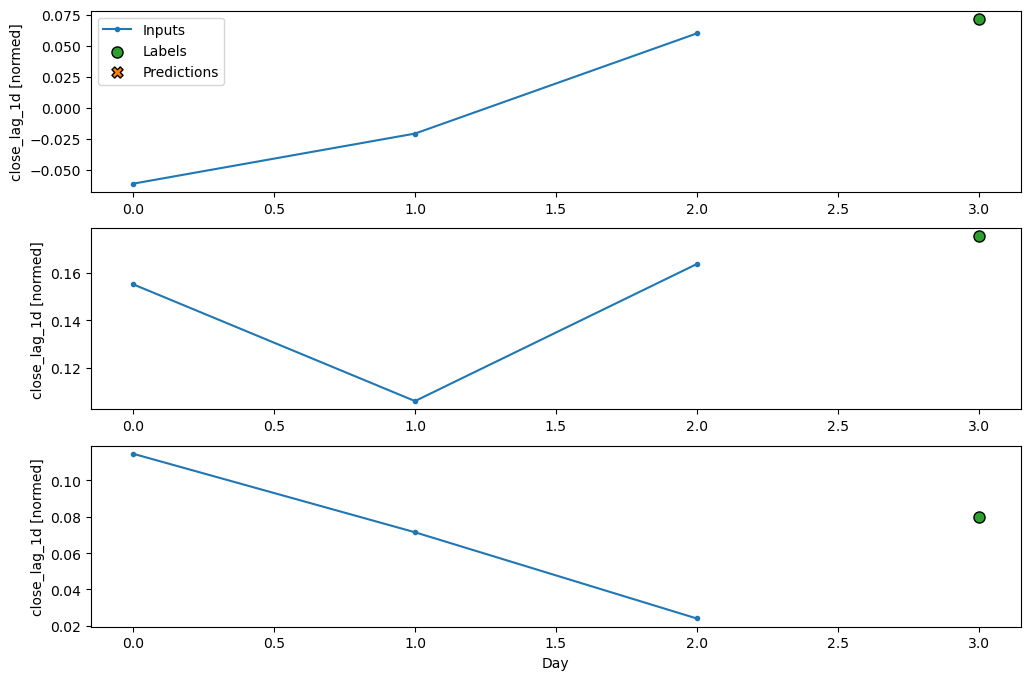

In [169]:
conv_window.plot(multi_step_dense)

In [170]:
# print('Input shape:', wide_window.example[0].shape)
# try:
#   print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
# except Exception as e:
#   print(f'\n{type(e).__name__}:{e}')